In [1]:
import pandas as pd
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('eventlog_large.csv', sep=';')
df.head()

,Case_ID,Activity,User,Timestamp
0,1,a,u2,2016-04-15 08:41:28
1,1,b,u3,2016-04-18 12:55:01
2,2,a,u2,2016-04-18 20:40:14
3,1,d,u5,2016-04-19 07:22:59
4,2,b,u4,2016-04-21 22:42:39


In [3]:
#Nodes dataframe for process flow
df_node = df.copy()
df_node = df_node[['Case_ID','Activity','Timestamp','User']]
df_node = df_node.sort_values(by=['Case_ID','Timestamp','Activity'],ascending=True).reset_index(drop=True)

df_node

,Case_ID,Activity,Timestamp,User
0,1,a,2016-04-15 08:41:28,u2
1,1,b,2016-04-18 12:55:01,u3
2,1,d,2016-04-19 07:22:59,u5
3,1,e,2016-04-23 15:06:58,u7
4,1,f,2016-04-24 19:18:32,u7
...,...,...,...,...
45374,7549,d,2120-07-15 03:40:37,u5
45375,7549,g,2120-07-19 05:39:32,u6
45376,7549,e,2120-07-20 18:29:17,u7
45377,7549,f,2120-07-22 03:43:02,u7


In [4]:
sortnew1 = df_node.iloc[:-1,:]
sortnew2 = df_node.iloc[1:,:].reset_index(drop=True)
sortnew = pd.concat([sortnew1,sortnew2],axis=1)
sortnew.columns = ['Case_ID','Start Activity','Start Time','Start User','Case_ID2','End Activity','End Time','End user']
sortnew['Comparison'] = sortnew.apply(lambda x: True if x['Case_ID'] == x['Case_ID2'] else False,axis=1)
sortnew = sortnew[sortnew['Comparison'] == True]

sortnew1 = sortnew[['Case_ID', 'Start User','End user']]
countsort = sortnew1.groupby(['Start User','End user']).size()
newcountsort = countsort.to_frame(name='Weight').reset_index()
newcountsort

,Start User,End user,Weight
0,u1,u3,2113
1,u1,u4,890
2,u2,u3,3168
3,u2,u4,1378
4,u3,u1,642
5,u3,u2,662
6,u3,u5,3155
7,u3,u6,822
8,u4,u1,285
9,u4,u2,277


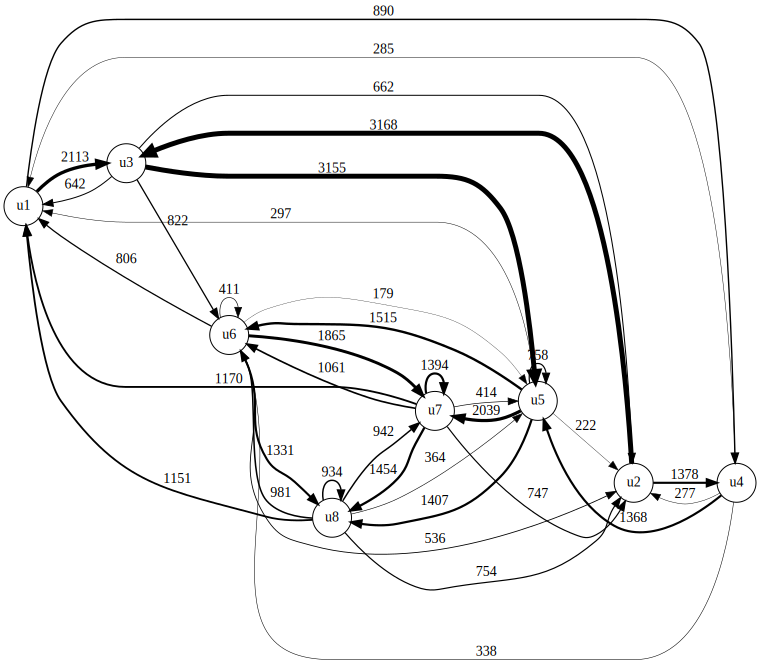

In [5]:
# Activity flow towards the users
G = graphviz.Digraph(format='jpeg')

G.attr(rankdir='LR')
G.attr('node', shape='circle')

max_node = 5
max_case_id = newcountsort['Weight'].max()

nodelist = []
for idx, row in newcountsort.iterrows():
    node1, node2, weight = [str(i) for i in row]
    
    if node1 not in nodelist:
        G.node(node1)
        nodelist.append(node2)
    if node2 not in nodelist:
        G.node(node2)
        nodelist.append(node2)
        
    G.edge(node1, node2, label = weight, penwidth=str(int(weight)/max_case_id*max_node))
    
G

In [6]:
# Activity flow per activity
sortnew2 = sortnew[['Case_ID', 'Start Activity','End Activity']]
countsort2 = sortnew2.groupby(['Start Activity','End Activity']).size()
newcountsort1 = countsort2.to_frame(name='Weight').reset_index()
newcountsort1

,Start Activity,End Activity,Weight
0,a,b,7549
1,b,c,1866
2,b,d,5683
3,d,e,2820
4,d,g,2863
5,e,f,4724
6,e,g,959
7,f,g,1861
8,f,h,3822
9,g,e,2863


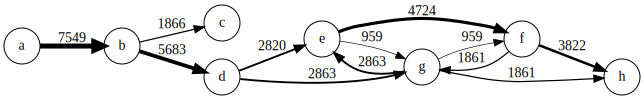

In [7]:
H = graphviz.Digraph(format='jpeg')

H.attr(rankdir='LR')
H.attr('node', shape='circle')

max_node = 5
max_case_id = newcountsort1['Weight'].max()

nodelist2 = []
for idx, row in newcountsort1.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        H.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        H.node(node22)
        nodelist2.append(node22)
        
    H.edge(node11, node22, label = weight2, penwidth=str(int(weight2)/max_case_id*max_node))
    
H

In [8]:
#Average Time per activity
sortnewtime = sortnew.copy()
sortnewtime['Start Time'] = pd.to_datetime(sortnewtime['Start Time'])
sortnewtime['End Time'] = pd.to_datetime(sortnewtime['End Time'])
sortnewtime['Duration'] = sortnewtime['End Time'] - sortnewtime['Start Time']

sortnewtime2 = sortnewtime.copy()
sortnewtime2 = sortnewtime2[['Start Activity','End Activity','Duration']]
sortnewtime2['Duration'] = sortnewtime2['Duration'].apply(lambda x: round(x.total_seconds(),0))
sortnewtime2 = sortnewtime2.groupby(['Start Activity','End Activity']).mean().reset_index()
sortnewtime2['Duration'] = round(sortnewtime2['Duration']/86400,2)
sortnewtime2

,Start Activity,End Activity,Duration
0,a,b,2.13
1,b,c,1.29
2,b,d,1.54
3,d,e,3.39
4,d,g,3.42
5,e,f,1.75
6,e,g,1.11
7,f,g,2.25
8,f,h,2.29
9,g,e,2.59


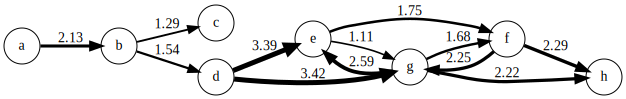

In [9]:
Z = graphviz.Digraph(format='jpeg')

Z.attr(rankdir='LR')
Z.attr('node', shape='circle')

max_node = 5
max_case_id = sortnewtime2['Duration'].max()

nodelist2 = []
for idx, row in sortnewtime2.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        Z.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        Z.node(node22)
        nodelist2.append(node22)
        
    Z.edge(node11, node22, label = weight2, penwidth=str(float(weight2)/max_case_id*max_node)) 
Z

In [10]:
# Individual activities per user
iapu = df_node.copy()
iapu = iapu[['Activity','User']]
iapu = iapu.groupby(['Activity','User']).size()
iapu = iapu.to_frame(name='Weight').reset_index()
iapu

,Activity,User,Weight
0,a,u1,3003
1,a,u2,4546
2,b,u3,5281
3,b,u4,2268
4,c,u1,927
5,c,u2,939
6,d,u5,4523
7,d,u6,1160
8,e,u7,3412
9,e,u8,2271


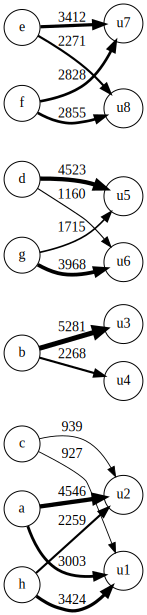

In [11]:
ZA = graphviz.Digraph(format='jpeg')

ZA.attr(rankdir='LR')
ZA.attr('node', shape='circle')

max_node = 5
max_case_id = iapu['Weight'].max()
nodelist2 = []
for idx, row in iapu.iterrows():
    node11, node22, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        ZA.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        ZA.node(node22)
        nodelist2.append(node22)
        
    ZA.edge(node11, node22, label = weight2, penwidth=str(int(weight2)/max_case_id*max_node))
ZA

In [12]:
# Average time a user spends on each activity
sortnewtime4 = sortnewtime.copy()
sortnewtime4 = sortnewtime4[['Start User','Start Activity','End Activity','Duration']]
sortnewtime4['Duration'] = sortnewtime4['Duration'].apply(lambda x: round(x.total_seconds(),0))

sortnewtime4 = sortnewtime4.groupby(['Start User','Start Activity','End Activity']).mean().reset_index()
sortnewtime4['Duration'] = round(sortnewtime4['Duration']/86400,2)
sortnewtime4

,Start User,Start Activity,End Activity,Duration
0,u1,a,b,2.13
1,u2,a,b,2.13
2,u3,b,c,1.29
3,u3,b,d,1.56
4,u4,b,c,1.27
5,u4,b,d,1.47
6,u5,d,e,3.42
7,u5,d,g,3.46
8,u5,g,e,2.68
9,u5,g,f,1.25


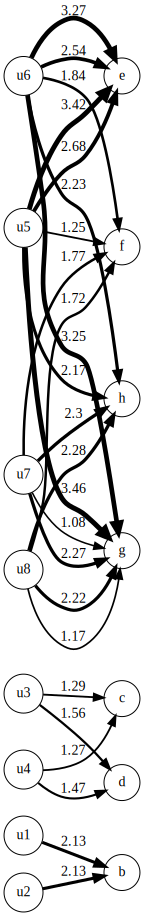

In [13]:
ZB = graphviz.Digraph(format='jpeg')

ZB.attr(rankdir='LR')
ZB.attr('node', shape='circle')

max_node = 5
max_case_id = sortnewtime4['Duration'].max()
nodelist2 = []

for idx, row in sortnewtime4.iterrows():
    node11, node22, node33, weight2 = [str(i) for i in row]
    
    if node11 not in nodelist2:
        ZB.node(node11)
        nodelist2.append(node22)
    if node22 not in nodelist2:
        ZB.node(node22)
        nodelist2.append(node22)
    if node33 not in nodelist2:
        ZB.node(node33)
        nodelist2.append(node33)
        
    ZB.edge(node11, node33, label = weight2, penwidth=str(float(weight2)/max_case_id*max_node))
ZB

In [14]:
df_plot = df_node.copy()
df_plot = df_plot[df_plot['Case_ID'] <= 20]
df_plot['Timestamp'] = pd.to_datetime(df_plot['Timestamp'])
df_plot

,Case_ID,Activity,Timestamp,User
0,1,a,2016-04-15 08:41:28,u2
1,1,b,2016-04-18 12:55:01,u3
2,1,d,2016-04-19 07:22:59,u5
3,1,e,2016-04-23 15:06:58,u7
4,1,f,2016-04-24 19:18:32,u7
...,...,...,...,...
115,19,f,2016-07-25 23:14:20,u8
116,19,h,2016-07-27 18:08:34,u2
117,20,a,2016-07-21 04:22:41,u2
118,20,b,2016-07-23 04:40:45,u3


Text(0.5, 0.98, 'Analyzing Events Timeline')

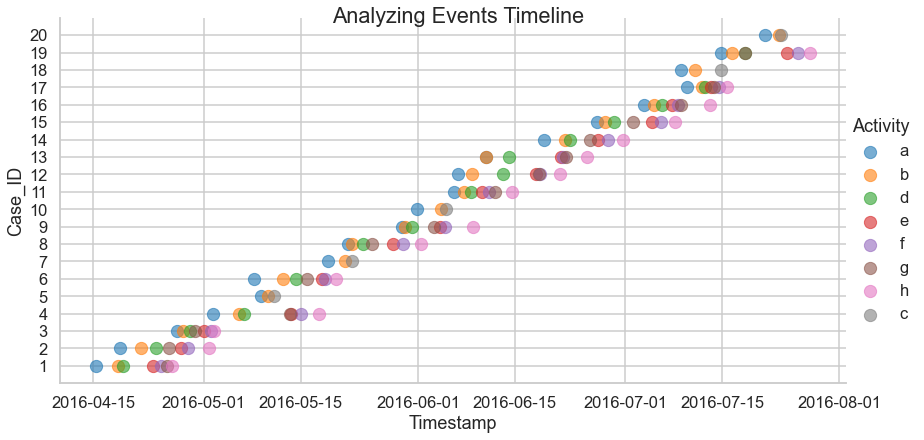

In [16]:
sns.set_style('whitegrid')
sns.set_context('talk')
activity_plot = sns.lmplot(x='Timestamp',y='Case_ID', data=df_plot, hue='Activity',height=6, aspect=2,fit_reg=False, scatter_kws={'s':150, 'alpha':0.6})
activity_plot.set(ylim=(0, max(df_plot['Case_ID'])+1), yticks=(df_plot['Case_ID']).unique())
activity_plot.fig.suptitle('Analyzing Events Timeline')